In [3]:
import requests
import pyvo as vo
import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GD1Koposov10, GD1, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

In [14]:
name='GAIA@AIP'
url='https://gaia.aip.de/tap'
token = <enter token>
tap_session = requests.Session()
tap_session.headers['Authorization'] = token
tap_service = vo.dal.TAPService(url, session=tap_session)

# Start episode 7: Photometry with reading candidate_df from hdf5 file in student download

In [6]:
filename = 'backup-data/gd1_data.hdf'
candidate_df = pd.read_hdf(filename, 'candidate_df')

Text(0.5, 0, 'Color (g-i)')

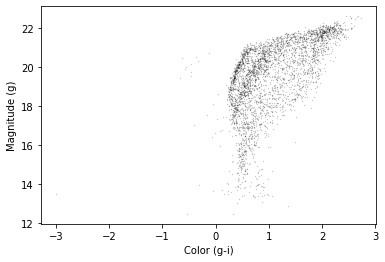

In [90]:
x = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
y = candidate_df['g_mean_psf_mag']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.ylabel('Magnitude (g)')
plt.xlabel('Color (g-i)')

(22.0, 14.0)

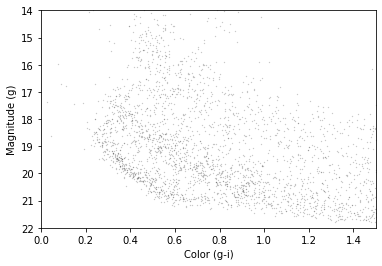

In [91]:
x = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
y = candidate_df['g_mean_psf_mag']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.ylabel('Magnitude (g)')
plt.xlabel('Color (g-i)')

plt.xlim([0, 1.5])
plt.ylim([22, 14])

In [92]:
def plot_cmd(table):
    """Plot a color magnitude diagram.
    
    table: Table or DataFrame with photometry data
    """
    y = table['g_mean_psf_mag']
    x = table['g_mean_psf_mag'] - table['i_mean_psf_mag']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlim([0, 1.5])
    plt.ylim([22, 14])

    plt.ylabel('Magnitude (g)')
    plt.xlabel('Color (g-i)')

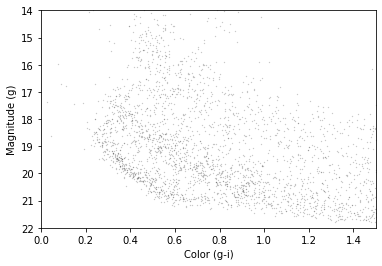

In [93]:
plot_cmd(candidate_df)

## Making a polygon

In [97]:
filename = 'gd1_isochrone.hdf5'
iso_df = pd.read_hdf(filename, 'iso_df')
iso_df.head()

,mag_g,color_g_i
0,28.294743,2.195021
1,28.189718,2.166076
2,28.051761,2.129312
3,27.916194,2.093721
4,27.780024,2.058585


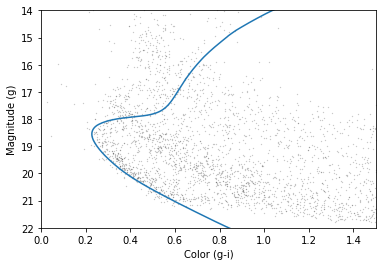

In [98]:
plot_cmd(candidate_df)
plt.plot(iso_df['color_g_i'], iso_df['mag_g']);

In [99]:
g_all = iso_df['mag_g']

g_mask = (g_all > 18.0) & (g_all < 21.5)
g_mask.sum()

117

In [100]:
iso_masked = iso_df[g_mask]
iso_masked.head()

,mag_g,color_g_i
94,21.411746,0.692171
95,21.322466,0.670238
96,21.233380,0.648449
97,21.144427,0.626924
98,21.054549,0.605461


In [101]:
g = iso_masked['mag_g']
left_color = iso_masked['color_g_i'] - 0.06
right_color = iso_masked['color_g_i'] + 0.12

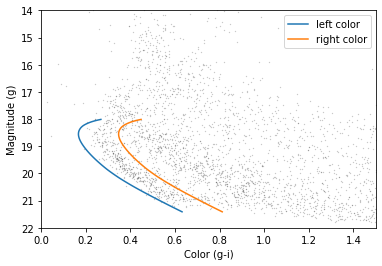

In [102]:
plot_cmd(candidate_df)

plt.plot(left_color, g, label='left color')
plt.plot(right_color, g, label='right color')

plt.legend();

## Which points are in the polygon?

In [103]:
reverse_right_color = right_color[::-1]


In [104]:
import numpy as np
color_loop = np.append(left_color, reverse_right_color)
color_loop.shape

(234,)

In [105]:
mag_loop = np.append(g, g[::-1])
mag_loop.shape

(234,)

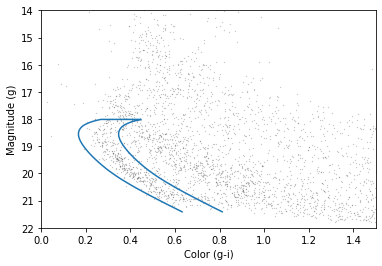

In [106]:
plot_cmd(candidate_df)
plt.plot(color_loop, mag_loop);

In [107]:
loop_df = pd.DataFrame()
loop_df['color_loop'] = color_loop
loop_df['mag_loop'] = mag_loop
loop_df.head()

,color_loop,mag_loop
0,0.632171,21.411746
1,0.610238,21.322466
2,0.588449,21.233380
3,0.566924,21.144427
4,0.545461,21.054549


In [108]:
from matplotlib.patches import Polygon

polygon = Polygon(loop_df)
polygon

### Exercise:
    When we encounter a new object, it is good to create a toy example to test that it does what we think it does. Define a list of two points (represented as two tuples), one that should be inside the polygon and one that should be outside the polygon. Call contains_points on the polygon we just created, passing it the list of points you defined, to verify that the results are as expected.

In [109]:
#Solution
test_points = [(0.4, 20), 
           (0.4, 16)]

test_inside_mask = polygon.contains_points(test_points)
test_inside_mask

array([ True, False])

## Save the polygon

In [110]:
filename = 'gd1_data.hdf'
loop_df.to_hdf(filename, 'loop_df')

## Selecting based on Photometry

In [111]:
cmd_df = pd.DataFrame()

cmd_df['color'] = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
cmd_df['mag'] = candidate_df['g_mean_psf_mag']

cmd_df.head()

,color,mag
0,0.3804,17.8978
1,1.6092,19.2873
2,0.4457,16.9238
3,1.5902,19.9242
4,1.4853,16.1516


In [112]:
inside_mask = polygon.contains_points(cmd_df)
inside_mask

array([False, False, False, ..., False, False, False])

### Exercise:

Boolean values are stored as 0s and 1s. FALSE = 0 and TRUE = 1. Use this information to determine the number of stars that fall inside the polygon.

In [113]:
#Solution
inside_mask.sum()

454

In [114]:
winner_df = candidate_df[inside_mask]

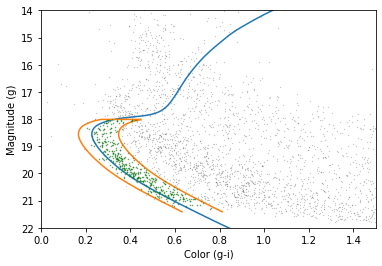

In [115]:
plot_cmd(candidate_df)
plt.plot(iso_df['color_g_i'], iso_df['mag_g'])
plt.plot(color_loop, mag_loop)

x = winner_df['g_mean_psf_mag'] - winner_df['i_mean_psf_mag']
y = winner_df['g_mean_psf_mag']
plt.plot(x, y, 'go', markersize=0.5, alpha=0.5);

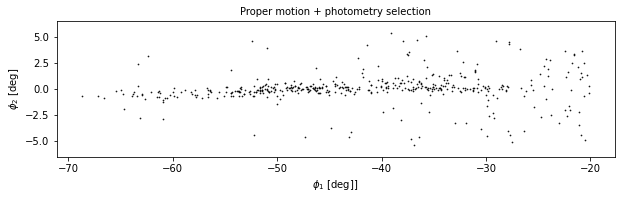

In [116]:
fig = plt.figure(figsize=(10,2.5))

x = winner_df['phi1']
y = winner_df['phi2']
plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('$\phi_1$ [deg]]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion + photometry selection', fontsize='medium')

plt.axis('equal');

In [117]:
def plot_cmd_selection(df):
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

    plt.xlabel('$\phi_1$ [deg]')
    plt.ylabel('$\phi_2$ [deg]')
    plt.title('Proper motion + photometry selection', fontsize='medium')

    plt.axis('equal')

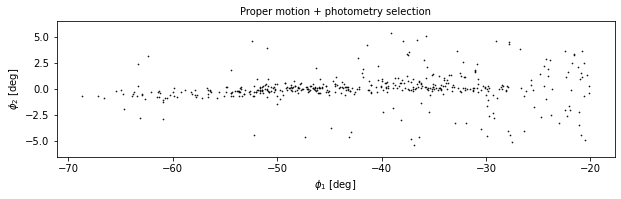

In [118]:
fig = plt.figure(figsize=(10,2.5))
plot_cmd_selection(winner_df)

In [119]:
filename = 'gd1_data.hdf'
winner_df.to_hdf(filename, 'winner_df')

In [120]:
MB = 1024 * 1024
getsize(filename) / MB

14.060470581054688